In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pandas numpy scikit-learn xgboost tensorflow

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

base_path = '/content/drive/MyDrive/AQI_Prediction_Dataset/'

files = ['city_day.csv', 'city_hour.csv', 'station_day.csv', 'station_hour.csv']

features = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']
target = 'AQI'

dataframes = []
for file in files:
    df = pd.read_csv(base_path + file)
    # Select only the relevant columns
    df = df[features + [target]]
    dataframes.append(df)

combined_df = pd.concat(dataframes, axis=0, ignore_index=True)

combined_df = combined_df.dropna(subset=[target])

combined_df[features] = combined_df[features].fillna(0)

X = combined_df[features]
y = combined_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Data preprocessing completed. Combined data from all files. Rows with missing AQI dropped. Missing feature values filled with 0.")
print(f"Dataset size after dropping missing AQI rows: {combined_df.shape[0]} rows")

<ipython-input-3-5acbc5902080>:15: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(base_path + file)


Data preprocessing completed. Combined data from all files. Rows with missing AQI dropped. Missing feature values filled with 0.
Dataset size after dropping missing AQI rows: 2709563 rows


In [4]:
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Reshape data for CNN (add a channel dimension)
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build CNN model
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(16, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)  # Output AQI
])

# Compile
cnn_model.compile(optimizer='adam', loss='mse')

# Train
cnn_model.fit(X_train_cnn, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Predict
y_pred = cnn_model.predict(X_test_cnn).flatten()

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("CNN Neural Network Results:")
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
54192/54192 ━━━━━━━━━━━━━━━━━━━━ 168s 3ms/step - loss: 9004.5586 - val_loss: 6985.2305
Epoch 2/5
54192/54192 ━━━━━━━━━━━━━━━━━━━━ 191s 3ms/step - loss: 7042.6963 - val_loss: 6708.8706
Epoch 3/5
54192/54192 ━━━━━━━━━━━━━━━━━━━━ 169s 3ms/step - loss: 6810.2183 - val_loss: 6595.9893
Epoch 4/5
54192/54192 ━━━━━━━━━━━━━━━━━━━━ 202s 3ms/step - loss: 6681.5552 - val_loss: 6569.5635
Epoch 5/5
54192/54192 ━━━━━━━━━━━━━━━━━━━━ 185s 3ms/step - loss: 6652.7676 - val_loss: 6745.8945
16935/16935 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step
CNN Neural Network Results:
MAE: 45.38, RMSE: 82.59, R²: 0.68


In [5]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize the model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, tree_method='gpu_hist')

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print results
print("XGBoost Regressor Results:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:34:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:34:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:34:41] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.


XGBoost Regressor Results:
Mean Absolute Error (MAE): 43.82
Mean Squared Error (MSE): 5704.29
Root Mean Squared Error (RMSE): 75.53
R² Score: 0.73


In [6]:
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Build the model
nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer for regression
])

# Compile the model
nn_model.compile(optimizer='adam', loss='mse')

# Train the model
nn_model.fit(X_train, y_train, epochs=2, batch_size=32, validation_split=0.2, verbose=1)

# Make predictions
y_pred = nn_model.predict(X_test).flatten()

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print results
print("Neural Network (MLP) Results:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
54192/54192 ━━━━━━━━━━━━━━━━━━━━ 141s 3ms/step - loss: 9160.6865 - val_loss: 6786.5503
Epoch 2/2
54192/54192 ━━━━━━━━━━━━━━━━━━━━ 140s 3ms/step - loss: 6741.2300 - val_loss: 6630.3516
16935/16935 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step
Neural Network (MLP) Results:
Mean Absolute Error (MAE): 46.87
Mean Squared Error (MSE): 6694.14
Root Mean Squared Error (RMSE): 81.82
R² Score: 0.68


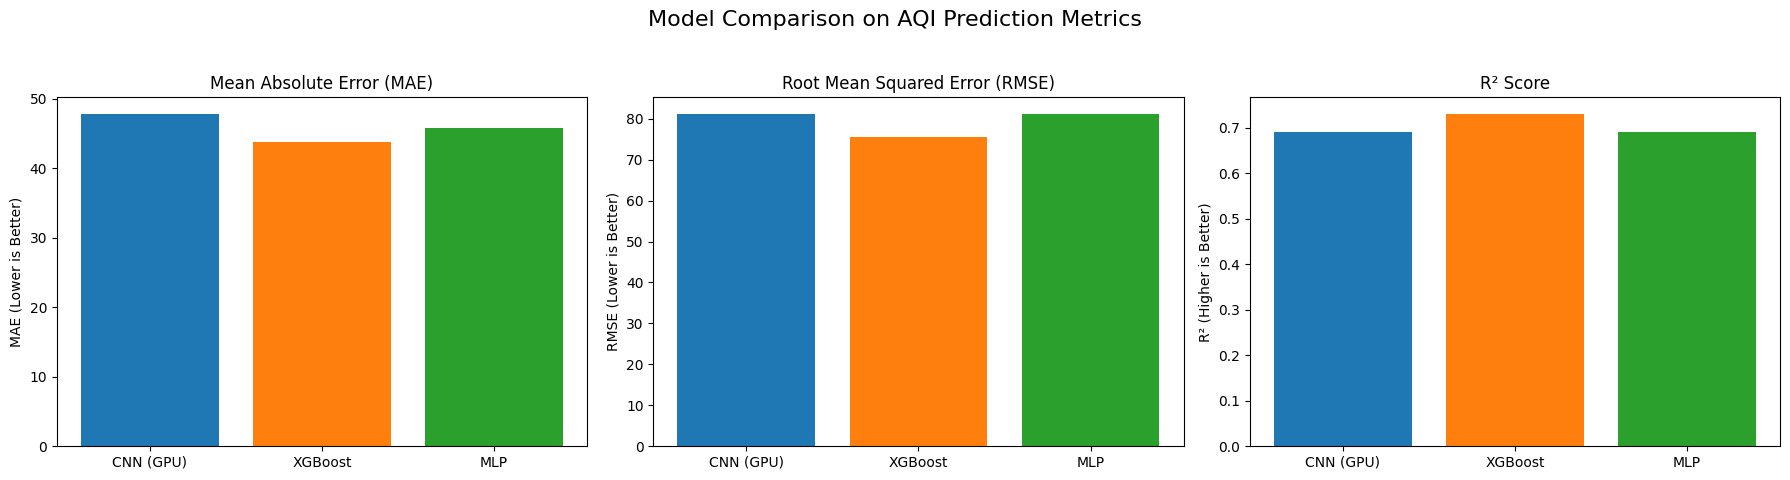

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Model Performance Metrics
models = ['CNN (GPU)', 'XGBoost', 'MLP']
mae = [47.82, 43.82, 45.76]
rmse = [81.16, 75.53, 81.14]
r2 = [0.69, 0.73, 0.69]

# Create a DataFrame for easier handling
data = pd.DataFrame({
    'Model': models,
    'MAE': mae,
    'RMSE': rmse,
    'R2 Score': r2
})

# Plotting individual metrics
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# MAE
axs[0].bar(models, mae, color=colors)
axs[0].set_title('Mean Absolute Error (MAE)')
axs[0].set_ylabel('MAE (Lower is Better)')

# RMSE
axs[1].bar(models, rmse, color=colors)
axs[1].set_title('Root Mean Squared Error (RMSE)')
axs[1].set_ylabel('RMSE (Lower is Better)')

# R2 Score
axs[2].bar(models, r2, color=colors)
axs[2].set_title('R² Score')
axs[2].set_ylabel('R² (Higher is Better)')

plt.suptitle('Model Comparison on AQI Prediction Metrics', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
